In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

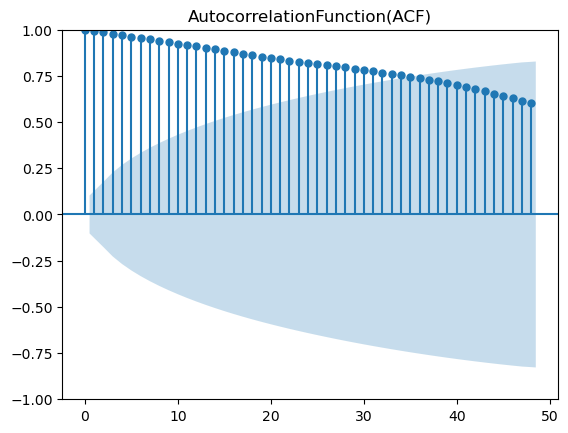

In [3]:
Bitcoin_A = pd.read_excel("C:/Users/lrodr/OneDrive/Documentos/master_ucm/trabajos/5/Bitcoin_A.xlsx")

#PlotACF
plot_acf(Bitcoin_A['PRECIO'],lags=48,alpha=0.05)
plt.title('AutocorrelationFunction(ACF)')
plt.show()

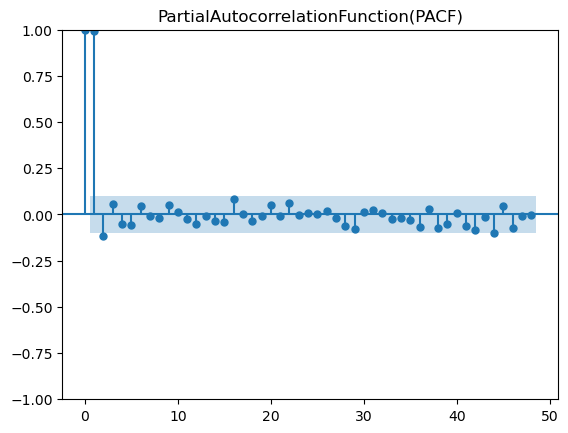

In [4]:
#PlotPACF
plot_pacf(Bitcoin_A['PRECIO'],lags=48,alpha=0.05)
plt.title('PartialAutocorrelationFunction(PACF)')
plt.show()

Text(0.5, 1.0, 'PACF')

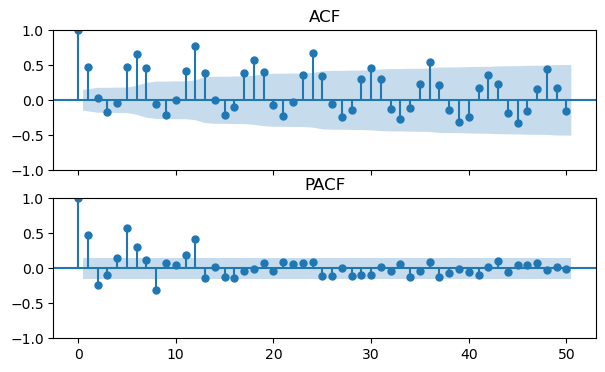

In [5]:
v_cordoba = pd.read_excel("C:/Users/lrodr/OneDrive/Documentos/master_ucm/trabajos/5/Cordoba.xlsx")

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(7,4),sharex=True)
plot_acf(v_cordoba['V_Resident'],ax=axs[0],lags=50,alpha=0.05)
axs[0].set_title('ACF')
plot_pacf(v_cordoba['V_Resident'],ax=axs[1],lags=50,alpha=0.05)
axs[1].set_title('PACF')

Text(0.5, 1.0, 'PreciodelBitcoin')

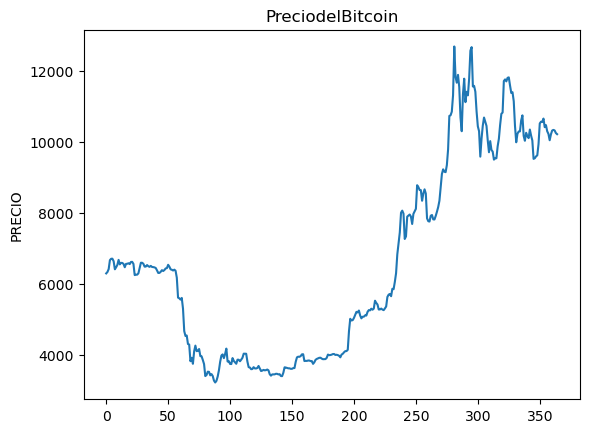

In [6]:
precio=Bitcoin_A['PRECIO']
sns.lineplot(precio)
plt.title('PreciodelBitcoin')

Text(0.5, 1.0, 'PreciodelBitcoin:seriediferenciada')

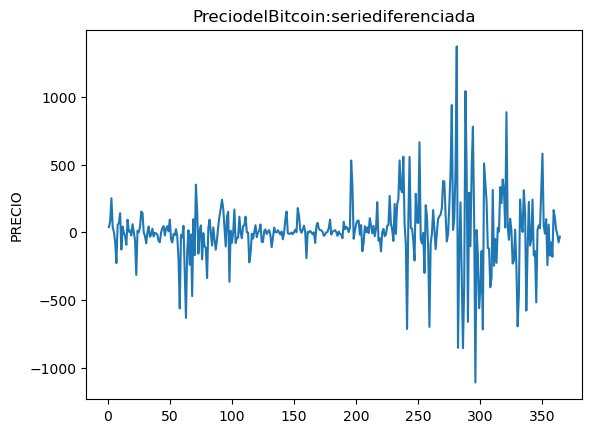

In [7]:
precio_diff = precio.diff().dropna()
sns.lineplot(precio_diff)
plt.title('PreciodelBitcoin:seriediferenciada')

Text(0.5, 1.0, 'ACF serie diferenciada')

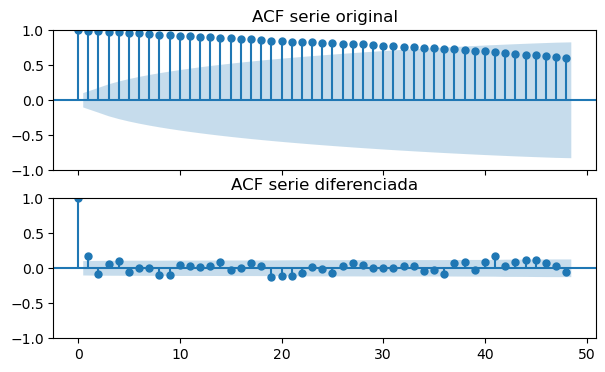

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(precio, ax=axs[0], lags=48, alpha=0.05)
axs[0].set_title('ACF serie original')
plot_acf(precio_diff, ax=axs[1], lags=48, alpha=0.05)
axs[1].set_title('ACF serie diferenciada')

Text(0.5, 1.0, 'ViajerosResidentes')

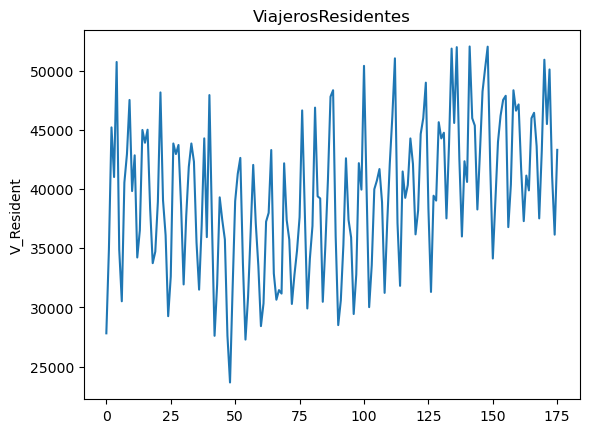

In [9]:
sns.lineplot(v_cordoba['V_Resident'])
plt.title('ViajerosResidentes')

Text(0.5, 1.0, 'ACF')

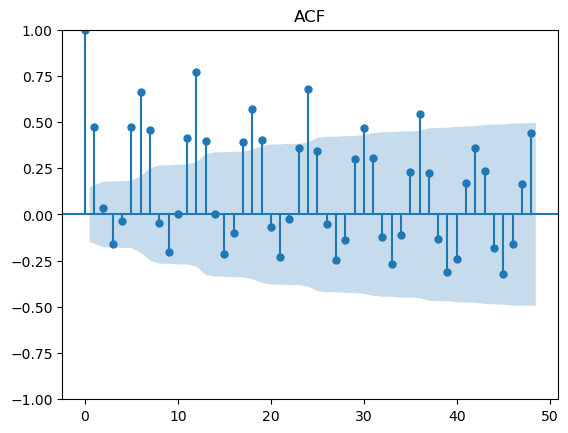

In [10]:
plot_acf(v_cordoba['V_Resident'],lags=48,alpha=0.05)
plt.title('ACF')

Text(0.5, 1.0, 'DIFF:ViajerosResidentes')

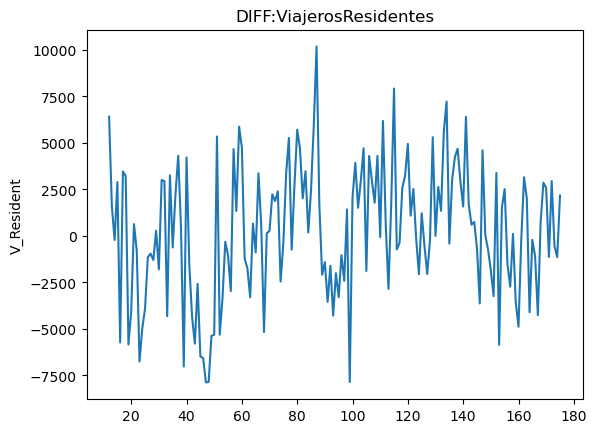

In [11]:
cordoba_diff=v_cordoba['V_Resident'].diff(12).dropna()
sns.lineplot(cordoba_diff)
plt.title('DIFF:ViajerosResidentes')

Text(0.5, 1.0, 'PACFseriediferenciada')

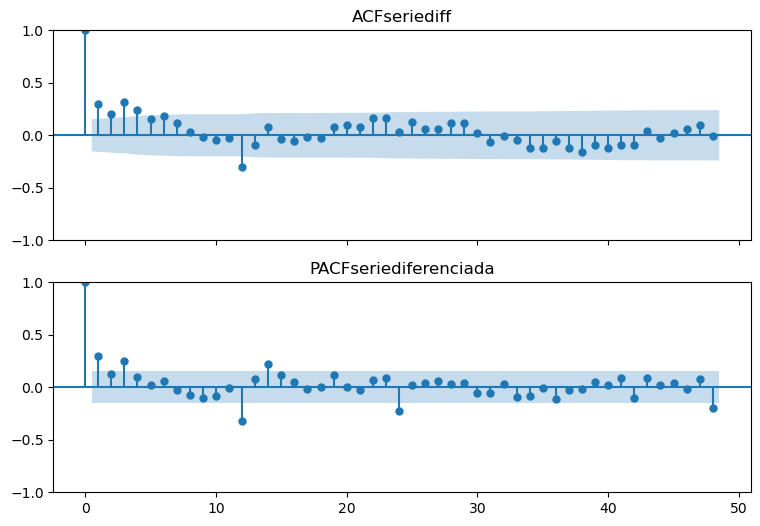

In [12]:
fig,axs=plt.subplots(nrows=2,ncols=1,
figsize=(9,6),sharex=True)
plot_acf(cordoba_diff,ax=axs[0],
lags=48,alpha=0.05)
axs[0].set_title('ACFseriediff')
plot_pacf(cordoba_diff,ax=axs[1],
lags=48,alpha=0.05)
axs[1].set_title('PACFseriediferenciada')

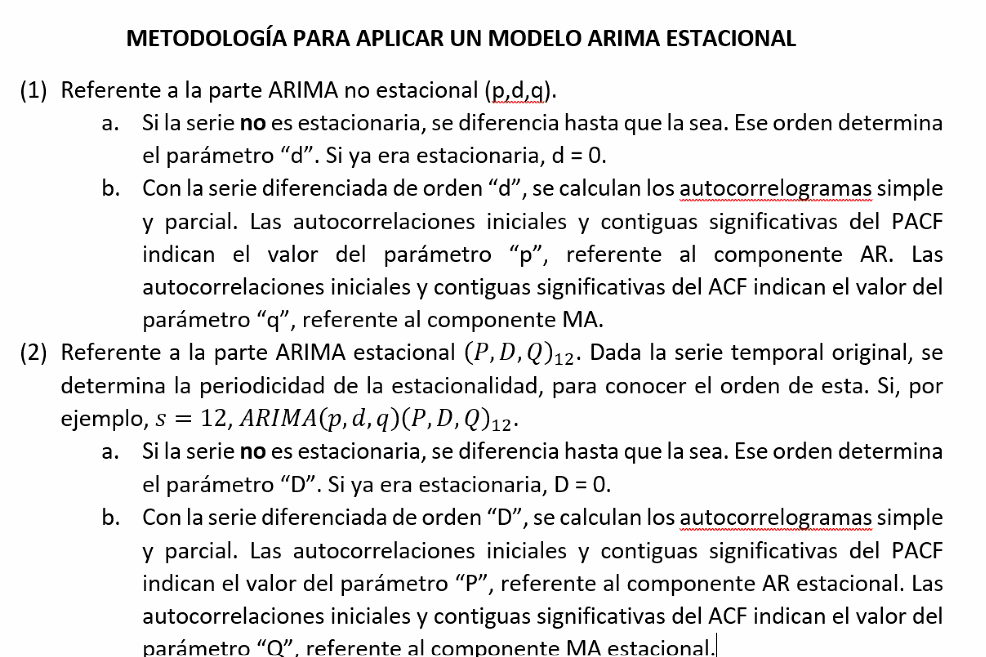

In [13]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
%pip install pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
%pip install skforecast
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import warnings

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Descarga datos
url=('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/consumos-combustibles-mensual.csv')
datos_t=pd.read_csv(url,sep=',')
datos_t=datos_t[['Fecha','Gasolinas']]
datos_t=datos_t.rename(columns={'Fecha':'date','Gasolinas':'litters'})
datos_t['date']=pd.to_datetime(datos_t['date'],format='%Y-%m-%d')
datos_t=datos_t.set_index('date')
datos=datos_t.loc[:'1980-01-01 00:00:00']
datos=datos.asfreq('MS')
datos=datos['litters']
datos.head()

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
Freq: MS, Name: litters, dtype: float64

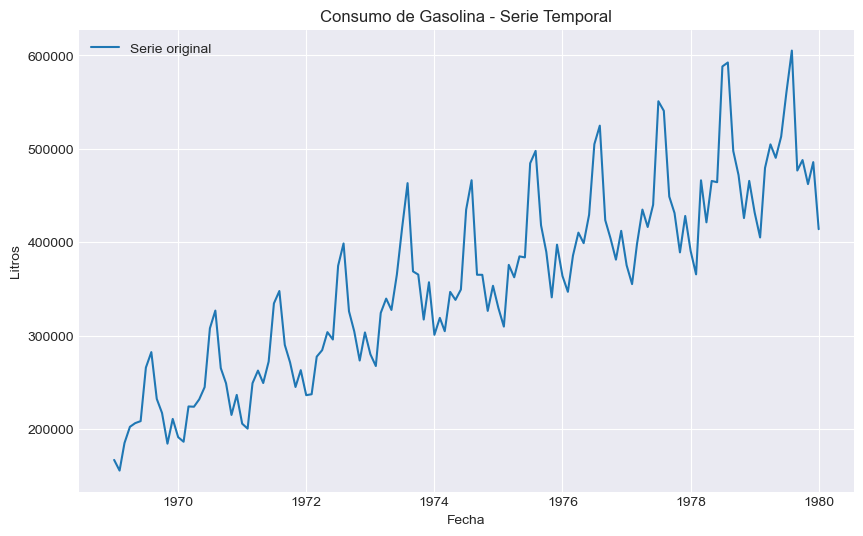

In [19]:
# Visualización de los datos
plt.figure(figsize=(10, 6))
plt.plot(datos, label='Serie original')
plt.title('Consumo de Gasolina - Serie Temporal')
plt.xlabel('Fecha')
plt.ylabel('Litros')
plt.legend()
plt.show()

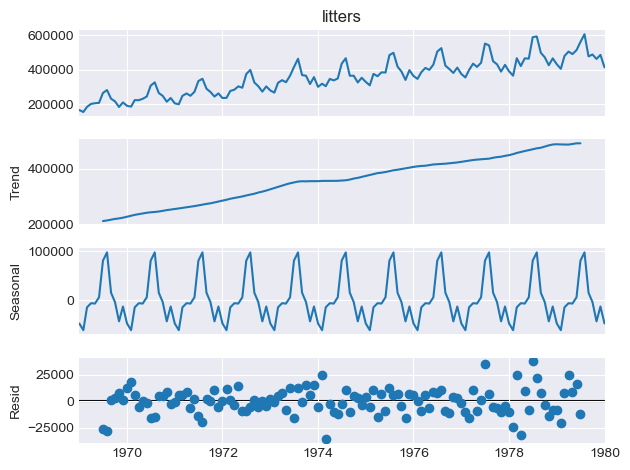

In [20]:
# Prueba de estacionariedad con Dickey-Fuller aumentado
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4],
        'Stationary': result[1] < 0.05
    }

adf_results_original = adf_test(datos)

# Descomposición estacional
decomposition = seasonal_decompose(datos, model='additive', period=12)
decomposition.plot()
plt.show()

<Figure size 1000x600 with 0 Axes>

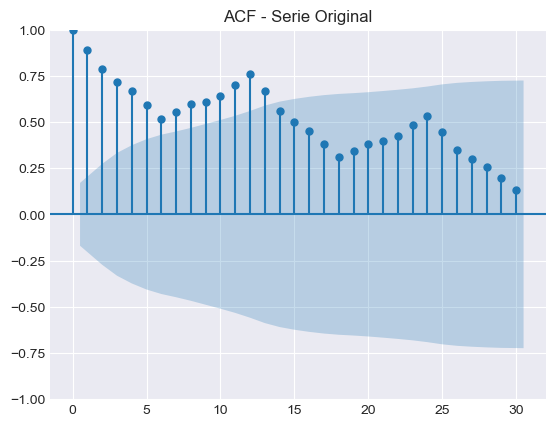

<Figure size 1000x600 with 0 Axes>

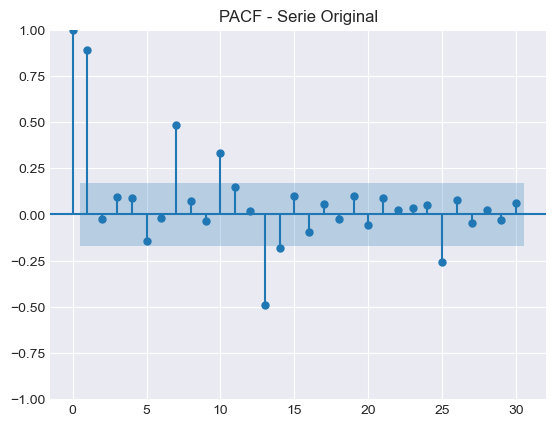

{'ADF Statistic': -1.1596066639173295,
 'p-value': 0.6907262160487554,
 'Critical Values': {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 'Stationary': False}

In [21]:
# Gráficos de autocorrelación y autocorrelación parcial
plt.figure(figsize=(10, 6))
plot_acf(datos, lags=30, title="ACF - Serie Original")
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(datos, lags=30, title="PACF - Serie Original", method='ywm')
plt.show()

# Resultados
adf_results_original

In [39]:
# Función para prueba ADF
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return 'ADF Statistic:', result[0], 'p-value', result[1],
        #'Critical Values': result[4],
        #'Stationary': result[1] < 0.05  # Si p < 0.05, rechazamos H0

# Función para prueba KPSS
def kpss_test(series, regression='c'):
    result = kpss(series, regression=regression, nlags="auto")
    return 'KPSS Statistic:', result[0], 'p-value', result[1],
        #'Critical Values': result[3],
        #'Stationary': result[1] > 0.05  # Si p > 0.05, aceptamos H0

print(
    "Test estacionariedad serie original\n",
    adf_test(datos),
    kpss_test(datos),
    "\n\n",
    "Test estacionariedad serie diferenciada de orden 1\n",
    adf_test(datos.diff().dropna()),
    adf_test(datos.diff().dropna()))

Test estacionariedad serie original
 ('ADF Statistic:', -1.1596066639173295, 'p-value', 0.6907262160487554) ('KPSS Statistic:', 1.8725434213925662, 'p-value', 0.01) 

 Test estacionariedad serie diferenciada de orden 1
 ('ADF Statistic:', -3.641727690032322, 'p-value', 0.00501160500213726) ('ADF Statistic:', -3.641727690032322, 'p-value', 0.00501160500213726)


C:\Users\lrodr\AppData\Local\Temp\ipykernel_15848\1112544607.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression, nlags="auto")
